# CNN + CIFAR10 + FSL
Purpose: Fit a NTK to a CNN intended for the CIFAR10 dataset. The purpose is to establish a baseline for the CIFAR10 experiments.

This is the FSL variant, which means that the model from the accuracy variant is now trained using only very limited data.

Furthermore, the PyTorch Lightning library is used for convenience.

In [1]:
# Imports
import numpy as np
import pandas as pd
import torch
from torch import nn
import lightning as L
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import matplotlib.pyplot as plt

import sys
sys.path.append('convkans/kan_convolutional')
from KANLinear import *

# Setup Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Setup Randomness -- https://lightning.ai/docs/pytorch/stable/common/trainer.html
L.seed_everything(68812, workers=True) # <--- Adjust the seed here for each trial run for the 5 seed values [42, 998244353, 10122024, 1000000007, 68812].

# CUDA Efficiency
if torch.cuda.is_available():
    torch.set_float32_matmul_precision('high')
    print("Configured CUDA Precision")

Seed set to 68812


Configured CUDA Precision


In [2]:
# Dataset Setup -- Inspired by Hugo's Dataset Reformatting
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = CIFAR10("./Experiments/temp/", train=True, download=True, transform=transform)
test_dataset = CIFAR10("./Experiments/temp/", train=False, download=True, transform=transform)

train_size = int(len(train_dataset) * 0.90)
val_size = int(len(train_dataset)) - train_size # Quite low validation size, but this is done to allow for greater model accuracy.
train_set, val_set = random_split(train_dataset, [train_size, val_size])

# Reformatted, due to odd issues when using NTK on it
class LCDataset(Dataset): # Lightning Compatible Dataset
    def __init__(self, dataset, num_classes, limit_per_class=-1, randomise=False):
        self.limit_per_class = limit_per_class
        self.num_classes = num_classes
        if self.limit_per_class != -1:
            sub = list(np.random.permutation(np.arange(len(dataset)))) # Generate a random permutation of the dataset.
            # Select the first x of each class
            sub2 = []
            sub_count = [0 for x in range(self.num_classes)]
            for x in sub:
                temp_x, temp_y = dataset[x]
                if sub_count[temp_y] != self.limit_per_class:
                    sub_count[temp_y] += 1
                    sub2.append(x)
            for x in sub_count:
                assert x == self.limit_per_class
            assert len(sub2) == self.num_classes * self.limit_per_class
            self.dataset = Subset(dataset, sub2)
        elif randomise == True: # Idea: Take 2 values each to form a pair to check against (FSL case)
            sub = list(np.random.permutation(np.arange(len(dataset)))) # Generate a random permutation of the dataset.
            self.dataset = Subset(dataset, sub)
        else:
            self.dataset = dataset
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        y_one_hot = torch.zeros(self.num_classes)
        y_one_hot[y] = 1
        return x, y_one_hot

batch_size = 64
train_loader = DataLoader(LCDataset(train_set, num_classes=10, limit_per_class=15), batch_size=batch_size, num_workers=10)
val_loader = DataLoader(LCDataset(val_set, num_classes=10), batch_size=batch_size, shuffle=False, num_workers=10)
test_loader = DataLoader(LCDataset(test_dataset, num_classes=10), batch_size=batch_size, num_workers=10)
similarity_loader = DataLoader(LCDataset(test_dataset, num_classes=10, randomise=True), batch_size=2, num_workers=10) # Each batch constitutes a pair

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Model Declaration
class ClassicCNN(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.BatchNorm2d(3),
            nn.Conv2d(3, 16, kernel_size=2, padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.GELU(),
            nn.Conv2d(16, 64, kernel_size=3, padding=0, bias=False),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.GELU(),
            nn.Conv2d(64, 96, kernel_size=3, padding=0, bias=False),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(2),
            nn.GELU(),
            nn.Flatten(1),
            nn.Dropout(p=0.50),
            nn.Linear(3456, 64, bias=False),
            nn.GELU(),
            nn.Dropout(p=0.50),
            nn.Linear(64, 10, bias=False)
        )
    
    def forward(self, x):
        return self.net(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = F.cross_entropy(y_pred, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        v1 = torch.argmax(y_pred, dim=1)
        v2 = torch.argmax(y, dim=1)
        loss = F.cross_entropy(y_pred, y)
        accuracy = torch.sum(torch.eq(v1, v2)) / len(y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", accuracy, prog_bar=True) # Observe model accuracy with time

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        v1 = torch.argmax(y_pred, dim=1)
        v2 = torch.argmax(y, dim=1)
        accuracy = torch.sum(torch.eq(v1, v2)) / len(y)
        self.log("accuracy", accuracy) # Accuracy for Accuracy vs. Parameter Experiment

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return self(batch)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        return optimizer

In [4]:
# Train + Test + Results
model = ClassicCNN()
trained_model = L.Trainer(max_epochs=100, deterministic=True, logger=CSVLogger(save_dir="Experiments/logs", name="CIFAR10CNNFSL", version="fin"), callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=5)], log_every_n_steps=1)
trained_model.fit(model, train_loader, val_loader)
trained_model.test(model, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 286 K  | train
--------------------------------------------
286 K     Trainable params
0         Non-trainable params
286 K     Total params
1.148     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.2809000015258789     │
└───────────────────────────┴───────────────────────────┘

[{'accuracy': 0.2809000015258789}]

In [5]:
logdata = pd.read_csv("Experiments/logs/CIFAR10CNNFSL/fin/metrics.csv")

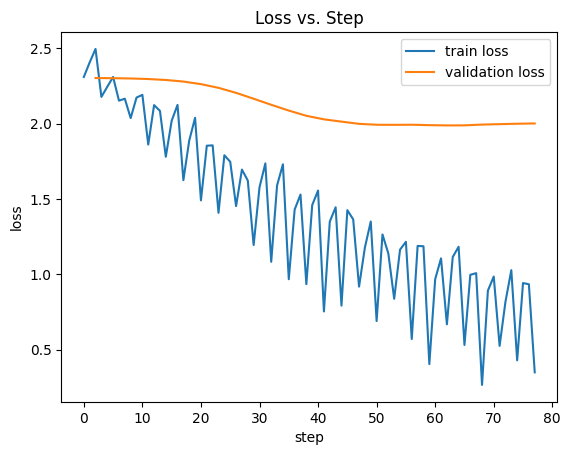

In [6]:
traindeflog = logdata.loc[logdata['train_loss'].notna(), ['step', 'train_loss']]
valdeflog = logdata.loc[logdata['val_loss'].notna(), ['step', 'val_loss']]
fig, ax = plt.subplots()
ax.plot(traindeflog['step'], traindeflog['train_loss'], label="train loss")
ax.plot(valdeflog['step'], valdeflog['val_loss'], label="validation loss")
ax.set(xlabel="step", ylabel="loss", title="Loss vs. Step")
plt.legend(loc="upper right")
plt.show()

In [7]:
def check_fsl_similarity(model, dataloader): # Must use a batch size of 2 for this to work
    res = 0.0
    sumlength = 0
    model.eval()
    model.to(device)
    for it in iter(dataloader):
        x, y = it
        if len(x) != 2:
            print(f'Broke loop at: {sumlength} runs.')
            break
        x = x.to(device)
        y = y.to(device)
        fx = model.forward(x)
        if (torch.argmax(fx[0]) != torch.argmax(fx[1]) and torch.argmax(y[0]) != torch.argmax(y[1])) or (torch.argmax(fx[0]) == torch.argmax(fx[1]) and torch.argmax(y[0]) == torch.argmax(y[1])):
            res += 1
        sumlength += 1
    return res, sumlength

In [8]:
rescnn, sumlengthcnn = check_fsl_similarity(model, similarity_loader)
print(f'CNN FSL Score: {rescnn / sumlengthcnn} on {sumlengthcnn} random samples')

CNN FSL Score: 0.8304 on 5000 random samples


In [9]:
# R: True Value, C: Predicted Value
def make_predict_matrix(model, dataloader):
    res = np.zeros(shape=(10, 10), dtype=int)
    model = model.to(device)
    for it in iter(dataloader):
        x, y = it
        x = x.to(device)
        y = y.to(device)
        x_arg = torch.argmax(model.forward(x), dim=1)
        y_arg = torch.argmax(y, dim=1)
        for i in range(len(x_arg)):
            res[y_arg[i], x_arg[i]] += 1
    return res

In [10]:
print(make_predict_matrix(model, test_loader))

[[281  63  83  18  57  26  16  51 293 112]
 [ 49 263 109  25  21 135  23  65 145 165]
 [ 78  31 104  59 209 155 188  67  55  54]
 [ 24  16 137 203  63 195 147 108  41  66]
 [ 52  12  97  50 244 136 266  98  29  16]
 [ 16  22 149 176  90 252  94 134  30  37]
 [ 10  12  41  83 178 117 450  40  12  57]
 [ 24  24  53  70 146 169  93 293  23 105]
 [230  68  95  24  22  44  17  36 372  92]
 [ 60 165  76  31  38  62  17  59 145 347]]
